In [28]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain-openai


In [29]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver() #not fit for prod

In [30]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")   


1) Just like before, define the graph state and how new messages are added to state (getter/setter)

In [31]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict): #creating state as an extension of dict
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

    #defines state accorss one single graph invocation

graph_builder = StateGraph(State)

In [32]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model='gpt-4o-2024-08-06',
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # api_key="...",  # if you prefer to pass api key in directly instaed of using env vars
    # base_url="...",
    # organization="...",
    # other params...
)



2. Now, let's configure Tavily as a **tool by adding it to the tools array**; we also have a test invocation on tavily. We will also bind the toolkit to the LLM agent directly

In [33]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [34]:
_set_env("TAVILY_API_KEY")

Now, let's configure Tavily and bind it to the LLM as a tool

In [35]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2) #adding all the metadata here to make it easy to call the tool by its name
tools = [tool]
tool.invoke("hiring values morgan stanley") #could use to search company names and classify them

[{'url': 'https://www.indeed.com/cmp/Morgan-Stanley/about',
  'content': 'Since our founding in 1935, underpinning our history and legacy are five core values. By putting clients first, leading with exceptional ideas, doing the right thing, committing to diversity and inclusion, and giving back, Morgan Stanley aims to deliver tangible results for today with visionary thinking for the future.'},
 {'url': 'https://www.morganstanley.com/about-us/morgan-stanley-core-values',
  'content': "Do the Right Thing\nAct with integrity\nThink like an owner to create long-term shareholder value\nValue and reward honesty and character\nPut Clients First\nKeep the client's interests first\nWork with colleagues to deliver the best of the Firm to every client\nListen to what the client is saying and needs\nLead with Exceptional Ideas\nWin by breaking new ground\nLeverage different perspectives to gain new insight\nDrive innovation\nBe vigilant about what we can do better\nCommit to Diversity & Inclusion

In [36]:
llm_with_tools = llm.bind_tools(tools)#bind toolkit to node

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next, let's define an `interface` to communnicate with the tools and to define them as a node.

This class has one single method which is __call__ which simply:
- maps the array of tool calls to the available tools and passes to the tools the adequate `args`
- appends the tool calls answers to the `state`

The tool node is then added to the graph as any node

In [37]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage.
    
    interface ToolCall {
        name: string;
        args: Record<string, unknown>;
        id: string;
    }
    
    interface Message {
        message:str[]
        tool_calls: ToolCall[];
    }

    interface Inputs {
        messages: Message[];
    }
    
    """

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}#key:value pairs

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []): #retrieving the message prop in the key-value pair; if key doesn't exist, return an empty list
            message = messages[-1] #fetch latest message as message
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls: #message is expected to contain a prop called tool call
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            ) #pass tool invocation arguments to specific tool
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
    


tool_node = BasicToolNode(tools=[tool]) #build tools node
graph_builder.add_node("tools", tool_node)

Now, we construct a router to either have a tool call or to end the node

In [38]:
from typing import Literal


def route_tools( #returns END or tools depending on current state (last message in stack)
    state: State,
):
    """
    Router;
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list): #if list, get the last message
        ai_message = state[-1]
    elif messages := state.get("messages", []): #if dict; get the last message (as sometimes state include a tool call)
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot", #source
    route_tools, #The callable that determines the next node or nodes
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END}, #mapping of paths to node based on the ouput of the router
)

Now, let's define **`unconditional`** edges;

We'll also define a `checkpointer` to extend session behind a single interaction

In [39]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot") #to loop back tool invocation to chatbot
graph_builder.add_edge(START, "chatbot") #node has a start and a finish arg; start -> chatbot
graph = graph_builder.compile(checkpointer=memory,interrupt_before=["tools"])

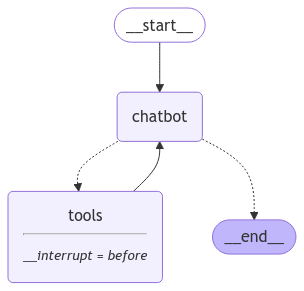

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now, let's invoke all calls with memory by defining a `config` and its `thread id`

In [41]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_MvEpwka5JujmBH7F2fz4eVrp)
 Call ID: call_MvEpwka5JujmBH7F2fz4eVrp
  Args:
    query: LangGraph programming language


In [57]:
from pprint import pprint
snapshot = graph.get_state(config)
snapshot.next
pprint(snapshot, indent=4)

StateSnapshot(values={'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='3a714374-1a47-4676-9287-f80093f24283'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MvEpwka5JujmBH7F2fz4eVrp', 'function': {'arguments': '{"query":"LangGraph programming language"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 94, 'total_tokens': 116, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bc6ad02c-773b-4afe-8f1a-0663fedf748d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {

In [44]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls 
#fetch last message to see state

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph programming language'},
  'id': 'call_MvEpwka5JujmBH7F2fz4eVrp',
  'type': 'tool_call'}]

In [45]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_MvEpwka5JujmBH7F2fz4eVrp)
 Call ID: call_MvEpwka5JujmBH7F2fz4eVrp
  Args:
    query: LangGraph programming language
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://analyticsindiamag.com/ai-features/top-7-simple-courses-to-build-ai-agents-using-langgraph/", "content": "Andrew Ng, the founder of DeepLearning.AI, recently launched a new course on building single and multi-agent LLM applications using LangGraph.. LangGraph is a framework within the LangChain ecosystem designed explicitly to build AI agents using a graph-based approach. It allows developers to structure complex interactions and workflows visually, making them easier to manage and understand."}, {"url": "https://blog.futuresmart.ai/langgraph-tutorial-for-beginners", "content": "By representing workflows as cyclical 

Here we notice a couple of things:
- Interrupts are part of state, so with the right thread_Id we can hang the graph state indefinitely
- Threat_id can be case_id for graph states